# Data for xgboost implementation

In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from xgboost import XGBRegressor
import seaborn as sns

# Load Data

In [11]:
df = pd.read_csv(r'predict_podcast_listening_train.csv')
df_test = pd.read_csv(r'podcast_listening_time_test.csv')


# Understand the data

In [12]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [13]:
# There are 3 columns with missing values: 'Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads'
missing_percentages = (df.isnull().mean() * 100).sort_values(ascending=False)
missing_values = missing_percentages[missing_percentages > 0]
print(missing_values)
print('Test data missing values')
print('-'*40)
missing_percentages = (df_test.isnull().mean() * 100).sort_values(ascending=False)
missing_values = missing_percentages[missing_percentages > 0]
print(missing_values)

Guest_Popularity_percentage    19.470667
Episode_Length_minutes         11.612400
Number_of_Ads                   0.000133
dtype: float64
Test data missing values
----------------------------------------
Guest_Popularity_percentage    19.5328
Episode_Length_minutes         11.4944
dtype: float64


In [14]:
df['Number_of_Ads'].fillna(df['Number_of_Ads'].median(), inplace=True)
df_test['Episode_Length_minutes'].fillna(df_test['Episode_Length_minutes'].median(), inplace= True)

# same result with the test data
df_test['Episode_Length_minutes'].fillna(df_test['Episode_Length_minutes'].median(), inplace= True)

C:\Users\User\AppData\Local\Temp\ipykernel_12344\1514776548.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Number_of_Ads'].fillna(df['Number_of_Ads'].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_12344\1514776548.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                750000 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


# Data exploration and featuring data


In [16]:
df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


ValueError: Could not interpret value `ratio_Ads` for `x`. An entry with this name does not appear in `data`.

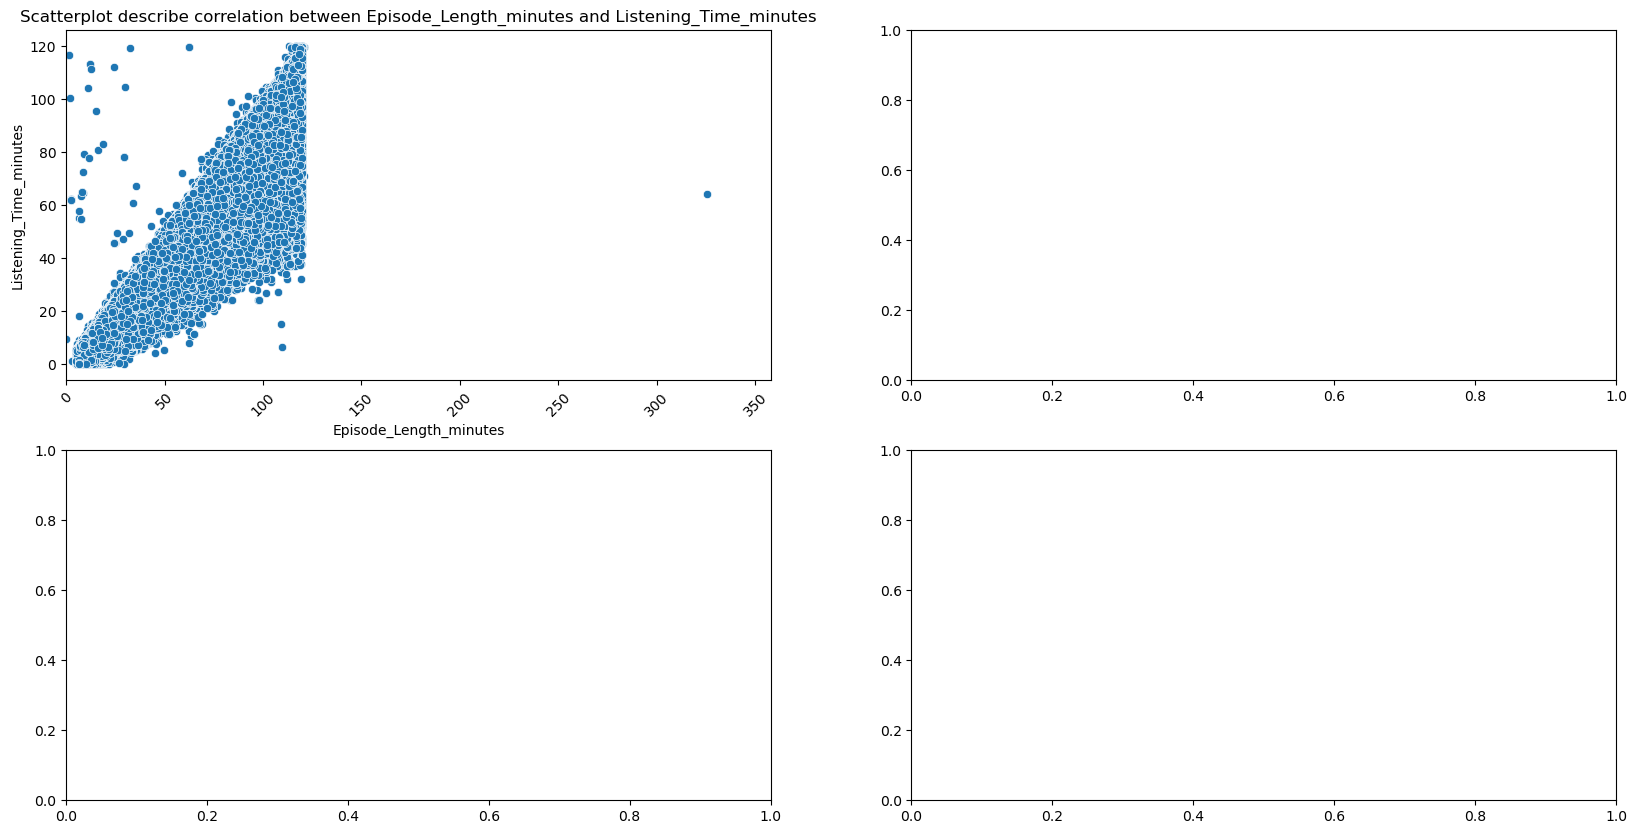

In [17]:
scatter = ['Episode_Length_minutes', 'ratio_Ads', 'Number_of_Ads']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for ax, i in zip(axes, scatter):
    sns.scatterplot(data = df,x = i, y = 'Listening_Time_minutes',ax = ax)
    ax.set_title(f'Scatterplot describe correlation between {i} and Listening_Time_minutes')
    ax.set_xlabel(i)
    ax.set_ylabel('Listening_Time_minutes')
    ax.set_xlim(0, df[i].max() * 1.1)
    for i in ax.get_xticklabels():
        i.set_rotation(45)
plt.tight_layout()
plt.show()
# Except Episode_Length_minutes, the other columns dont have a linear correlation with Listening_Time_minutes
# So we will feature all these columns

In [ ]:
sns.scatterplot(x = df['ratio_Ads'], y = df['Listening_Time_minutes'])

In [21]:
df[df['Number_of_Ads'] >  3]

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
211159,211159,Wellness Wave,Episode 83,64.83,Health,48.46,Sunday,Evening,NaN,53.37,Positive,50.44892
283606,283606,Health Hour,Episode 15,109.93,Health,67.81,Sunday,Morning,77.90,103.91,Neutral,103.89696
436577,436577,Sports Central,Episode 64,115.25,Sports,28.58,Saturday,Afternoon,23.65,103.00,Neutral,103.12686
495919,495919,Comedy Corner,Episode 79,64.83,Comedy,48.37,Saturday,Evening,NaN,53.42,Neutral,50.44892
537705,537705,Sound Waves,Episode 64,112.27,Music,28.95,Saturday,Morning,10.15,103.75,Neutral,103.12686
567235,567235,Detective Diaries,Episode 21,16.13,True Crime,49.11,Tuesday,Evening,43.17,12.00,Positive,6.49000
602553,602553,Sound Waves,Episode 53,112.27,Music,28.19,Tuesday,Morning,23.15,103.25,Neutral,103.12686
672139,672139,Sound Waves,Episode 35,115.74,Music,28.95,Tuesday,Afternoon,23.50,103.25,Neutral,103.12686
683147,683147,Crime Chronicles,Episode 15,109.93,True Crime,59.66,Tuesday,Evening,77.91,103.88,Neutral,103.89696


In [22]:
def popular(df):
    avg_popularity = 0
    if pd.isna(df['Guest_Popularity_percentage']):
        avg_popularity = df['Host_Popularity_percentage']
    else:
        avg_popularity = (df['Host_Popularity_percentage'] + df['Guest_Popularity_percentage']) / 2
    if avg_popularity <= 20:
        return 'Not Very Popular'
    elif 20 < avg_popularity <= 40:
        return 'Not Popular'
    elif 40 < avg_popularity <= 60:
        return 'Average'
    elif 60 < avg_popularity <= 80:
        return 'Popular'
    else:
        return 'Very Popular'

df['Popular_Level'] = df.apply(popular, axis=1)
df.drop(columns=['Host_Popularity_percentage', 'Guest_Popularity_percentage'], inplace=True)
df_test['Popular_Level'] = df_test.apply(popular, axis=1)
df_test.drop(columns=['Host_Popularity_percentage', 'Guest_Popularity_percentage'], inplace=True)

In [23]:
df['Episode_Title'] = df['Episode_Title'].str.replace('Episode ', '').astype(int)
df_test['Episode_Title'] = df_test['Episode_Title'].str.replace('Episode ', '').astype(int)



In [24]:
df['Podcast_Name'].value_counts()

Podcast_Name
Tech Talks             22847
Sports Weekly          20053
Funny Folks            19635
Tech Trends            19549
Fitness First          19488
Business Insights      19480
Style Guide            19364
Game Day               19272
Melody Mix             18889
Criminal Minds         17735
Finance Focus          17628
Detective Diaries      17452
Crime Chronicles       17374
Athlete's Arena        17327
Fashion Forward        17280
Tune Time              17254
Business Briefs        17012
Lifestyle Lounge       16661
True Crime Stories     16373
Sports Central         16191
Digital Digest         16171
Humor Hub              16144
Mystery Matters        16002
Comedy Corner          15927
Joke Junction          15074
Wellness Wave          15009
Sport Spot             14778
Gadget Geek            14770
Home & Living          14686
Laugh Line             14673
Life Lessons           14464
World Watch            14043
Sound Waves            13928
Global News            13649
M

In [25]:
def Podcast_Name(df):
    if df['Podcast_Name'] in ['Tech Talks','Tech Trends', 'Gadget Geek', 'Digital Digest', 'Innovators']:
        return 'Tech'
    elif df['Podcast_Name'] in ['Game Day', 'Sports Weekly', "Athlete's Arena", 'Sports Central', 'Sport Spot']:
        return 'Sports'
    elif df['Podcast_Name'] in ['Business Insights', 'Business Briefs', 'Finance Focus', 'Money Matters', 'Market Masters']:
        return 'Business'
    elif df['Podcast_Name'] in ['Global News', 'World Watch', 'Current Affairs', 'Daily Digest', 'News Roundup']:
        return 'News'
    elif df['Podcast_Name'] in ['Funny Folks', 'Humor Hub', 'Comedy Corner', 'Joke Junction', 'Laugh Line']:
        return 'Comedy'
    elif df['Podcast_Name'] in ['Melody Mix', 'Tune Time', 'Sound Waves', 'Music Matters']:
        return 'Music'
    elif df['Podcast_Name'] in ['Style Guide', 'Fashion Forward', 'Lifestyle Lounge', 'Home & Living', 'Life Lessons']:
        return 'Lifestyle'
    elif df['Podcast_Name'] in ['Study Sessions', 'Learning Lab', 'Educational Nuggets', 'Brain Boost']:
        return 'Education'
    elif df['Podcast_Name'] in ['Detective Diaries', 'Crime Chronicles', 'True Crime Stories', 'Criminal Minds', 'Mystery Matters']:
        return 'True Crime'
    elif df['Podcast_Name'] in ['Fitness First', 'Wellness Wave', 'Mind & Body', 'Healthy Living', 'Health Hour']:
        return 'Health'
    else:
        return 'Other'


df['Podcast_Name'] = df.apply(Podcast_Name, axis=1)
df_test['Podcast_Name'] = df_test.apply(Podcast_Name, axis=1)
df['Podcast_Name'].value_counts()

Podcast_Name
Sports        87621
Tech          86250
True Crime    84936
Lifestyle     82455
Comedy        81453
Business      80592
Health        71448
News          63390
Music         62723
Education     49132
Name: count, dtype: int64

In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      250000 non-null  int64  
 1   Podcast_Name            250000 non-null  object 
 2   Episode_Title           250000 non-null  int32  
 3   Episode_Length_minutes  250000 non-null  float64
 4   Genre                   250000 non-null  object 
 5   Publication_Day         250000 non-null  object 
 6   Publication_Time        250000 non-null  object 
 7   Number_of_Ads           250000 non-null  float64
 8   Episode_Sentiment       250000 non-null  object 
 9   Popular_Level           250000 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(6)
memory usage: 18.1+ MB


In [27]:
def genre(df):
    if df['Genre'] in ['Comedy', 'Music', 'Lifestyle']:
        return 'Entertainment'
    elif df['Genre'] in ['News', 'True Crime', 'Business']:
        return 'Events News'
    elif df['Genre'] in ['Health', 'Education', 'Technology']:
        return 'Information'
    elif df['Genre'] in ['Sports']:
        return 'Sports'
    else:
        return 'Other'
df['Genre'] = df.apply(genre, axis=1)
df_test['Genre'] = df_test.apply(genre, axis=1)

In [28]:
df['ratio_Ads'] = df['Number_of_Ads'] / df['Episode_Length_minutes']
df_test['ratio_Ads'] = df_test['Number_of_Ads'] / df_test['Episode_Length_minutes']

# Feature Engineering

In [29]:
pip install featuretools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from itertools import combinations
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [52]:
# Efficient Combination Processing
def process_combinations_fast(df, columns_to_encode, pair_size, max_batch_size=2000):
    str_df = df[columns_to_encode].astype(str)
    le = LabelEncoder()
    
    if isinstance(pair_size, int):
        pair_size = [pair_size]

    total_new_cols = 0
    for r in pair_size:
        print(f"\nProcessing {r}-combinations...")
        combos_iter = combinations(columns_to_encode, r)
        n_combinations = np.math.comb(len(columns_to_encode), r)
        print(f"Total {r}-combinations to process: {n_combinations}")

        batch_cols = []
        batch_names = []

        with tqdm(total=n_combinations, desc=f"{r}-combinations") as pbar:
            while True:
                batch_cols.clear()
                batch_names.clear()

                for _ in range(max_batch_size):
                    try:
                        cols = next(combos_iter)
                        batch_cols.append(list(cols))
                        batch_names.append('+'.join(cols))
                    except StopIteration:
                        break

                if not batch_cols:
                    break

                for cols, new_name in zip(batch_cols, batch_names):
                    result = str_df[cols[0]].copy()
                    for col in cols[1:]:
                        result += str_df[col]
                    df[new_name] = le.fit_transform(result) + 1
                    pbar.update(1)

                total_new_cols += len(batch_cols)

        print(f"Completed {r}-combinations. Total columns now: {len(df.columns)}")
    return df

In [53]:
df.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Publication_Day', 'Publication_Time', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes', 'Popular_Level',
       'ratio_Ads'],
      dtype='object')

In [80]:
# Process Combinations
df_test = process_combinations_fast(df_test, 
    ['Episode_Length_minutes', 'Episode_Title', 'Publication_Time',  
     'Number_of_Ads', 'Episode_Sentiment', 'Publication_Day', 'Podcast_Name', 'Genre', 'Popular_Level'], 
    [2, 3, 5], 
    max_batch_size=1000
)

C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_combinations = np.math.comb(len(columns_to_encode), r)



Processing 2-combinations...
Total 2-combinations to process: 36


2-combinations: 100%|██████████| 36/36 [00:07<00:00,  4.83it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_combinations = np.math.comb(len(columns_to_encode), r)


Completed 2-combinations. Total columns now: 46

Processing 3-combinations...
Total 3-combinations to process: 84


3-combinations:  68%|██████▊   | 57/84 [00:28<00:04,  6.42it/s]C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = le.fit_transform(result) + 1
3-combinations:  69%|██████▉   | 58/84 [00:28<00:04,  6.26it/s]C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = le.fit_transform(result) + 1
3-combinations:  70%|███████   | 59/84 [00:28<00:04,  6.17it/s]C:\Users\User\AppData\Local\Tem

Completed 3-combinations. Total columns now: 130

Processing 5-combinations...
Total 5-combinations to process: 126


5-combinations:   0%|          | 0/126 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = le.fit_transform(result) + 1
5-combinations:   1%|          | 1/126 [00:01<02:44,  1.31s/it]C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = le.fit_transform(result) + 1
5-combinations:   2%|▏         | 2/126 [00:02<02:40,  1.30s/it]C:\Users\User\AppData\Local\Temp\ipyker

Completed 5-combinations. Total columns now: 256


In [55]:
# Process Combinations
df = process_combinations_fast(df, 
    ['Episode_Length_minutes', 'Episode_Title', 'Publication_Time',  
     'Number_of_Ads', 'Episode_Sentiment', 'Publication_Day', 'Podcast_Name', 'Genre', 'Popular_Level'], 
    [2, 3, 5], 
    max_batch_size=1000
)

C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_combinations = np.math.comb(len(columns_to_encode), r)



Processing 2-combinations...
Total 2-combinations to process: 36


2-combinations: 100%|██████████| 36/36 [00:33<00:00,  1.08it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_combinations = np.math.comb(len(columns_to_encode), r)


Completed 2-combinations. Total columns now: 60

Processing 3-combinations...
Total 3-combinations to process: 84


3-combinations:  67%|██████▋   | 56/84 [02:21<00:20,  1.38it/s]C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = le.fit_transform(result) + 1
3-combinations:  68%|██████▊   | 57/84 [02:22<00:19,  1.35it/s]C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = le.fit_transform(result) + 1
3-combinations:  69%|██████▉   | 58/84 [02:23<00:18,  1.37it/s]C:\Users\User\AppData\Local\Tem

Completed 3-combinations. Total columns now: 132

Processing 5-combinations...
Total 5-combinations to process: 126


5-combinations:   0%|          | 0/126 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = le.fit_transform(result) + 1
5-combinations:   1%|          | 1/126 [00:07<15:48,  7.59s/it]C:\Users\User\AppData\Local\Temp\ipykernel_12344\4097388986.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = le.fit_transform(result) + 1
5-combinations:   2%|▏         | 2/126 [00:15<16:36,  8.04s/it]C:\Users\User\AppData\Local\Temp\ipyker

Completed 5-combinations. Total columns now: 258


>Visualization all the categories variables# 

In [82]:
df_test

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Publication_Day,Publication_Time,Number_of_Ads,Episode_Sentiment,Popular_Level,ratio_Ads,Episode_Length_minutes+Episode_Title,Episode_Length_minutes+Publication_Time,Episode_Length_minutes+Number_of_Ads,Episode_Length_minutes+Episode_Sentiment,Episode_Length_minutes+Publication_Day,Episode_Length_minutes+Podcast_Name,Episode_Length_minutes+Genre,Episode_Length_minutes+Popular_Level,Episode_Title+Publication_Time,Episode_Title+Number_of_Ads,Episode_Title+Episode_Sentiment,Episode_Title+Publication_Day,Episode_Title+Podcast_Name,Episode_Title+Genre,Episode_Title+Popular_Level,Publication_Time+Number_of_Ads,Publication_Time+Episode_Sentiment,Publication_Time+Publication_Day,Publication_Time+Podcast_Name,Publication_Time+Genre,Publication_Time+Popular_Level,Number_of_Ads+Episode_Sentiment,Number_of_Ads+Publication_Day,Number_of_Ads+Podcast_Name,Number_of_Ads+Genre,Number_of_Ads+Popular_Level,Episode_Sentiment+Publication_Day,Episode_Sentiment+Podcast_Name,Episode_Sentiment+Genre,Episode_Sentiment+Popular_Level,Publication_Day+Podcast_Name,Publication_Day+Genre,Publication_Day+Popular_Level,Podcast_Name+Genre,Podcast_Name+Popular_Level,Genre+Popular_Level,Episode_Length_minutes+Episode_Title+Publication_Time,Episode_Length_minutes+Episode_Title+Number_of_Ads,Episode_Length_minutes+Episode_Title+Episode_Sentiment,Episode_Length_minutes+Episode_Title+Publication_Day,Episode_Length_minutes+Episode_Title+Podcast_Name,Episode_Length_minutes+Episode_Title+Genre,Episode_Length_minutes+Episode_Title+Popular_Level,Episode_Length_minutes+Publication_Time+Number_of_Ads,Episode_Length_minutes+Publication_Time+Episode_Sentiment,Episode_Length_minutes+Publication_Time+Publication_Day,Episode_Length_minutes+Publication_Time+Podcast_Name,Episode_Length_minutes+Publication_Time+Genre,Episode_Length_minutes+Publication_Time+Popular_Level,Episode_Length_minutes+Number_of_Ads+Episode_Sentiment,Episode_Length_minutes+Number_of_Ads+Publication_Day,Episode_Length_minutes+Number_of_Ads+Podcast_Name,Episode_Length_minutes+Number_of_Ads+Genre,Episode_Length_minutes+Number_of_Ads+Popular_Level,Episode_Length_minutes+Episode_Sentiment+Publication_Day,Episode_Length_minutes+Episode_Sentiment+Podcast_Name,Episode_Length_minutes+Episode_Sentiment+Genre,Episode_Length_minutes+Episode_Sentiment+Popular_Level,Episode_Length_minutes+Publication_Day+Podcast_Name,Episode_Length_minutes+Publication_Day+Genre,Episode_Length_minutes+Publication_Day+Popular_Level,Episode_Length_minutes+Podcast_Name+Genre,Episode_Length_minutes+Podcast_Name+Popular_Level,Episode_Length_minutes+Genre+Popular_Level,Episode_Title+Publication_Time+Number_of_Ads,Episode_Title+Publication_Time+Episode_Sentiment,Episode_Title+Publication_Time+Publication_Day,Episode_Title+Publication_Time+Podcast_Name,Episode_Title+Publication_Time+Genre,Episode_Title+Publication_Time+Popular_Level,Episode_Title+Number_of_Ads+Episode_Sentiment,Episode_Title+Number_of_Ads+Publication_Day,Episode_Title+Number_of_Ads+Podcast_Name,Episode_Title+Number_of_Ads+Genre,Episode_Title+Number_of_Ads+Popular_Level,Episode_Title+Episode_Sentiment+Publication_Day,Episode_Title+Episode_Sentiment+Podcast_Name,Episode_Title+Episode_Sentiment+Genre,Episode_Title+Episode_Sentiment+Popular_Level,Episode_Title+Publication_Day+Podcast_Name,Episode_Title+Publication_Day+Genre,Episode_Title+Publication_Day+Popular_Level,Episode_Title+Podcast_Name+Genre,Episode_Title+Podcast_Name+Popular_Level,Episode_Title+Genre+Popular_Level,Publication_Time+Number_of_Ads+Episode_Sentiment,Publication_Time+Number_of_Ads+Publication_Day,Publication_Time+Number_of_Ads+Podcast_Name,Publication_Time+Number_of_Ads+Genre,Publication_Time+Number_of_Ads+Popular_Level,Publication_Time+Episode_Sentiment+Publication_Day,Publication_Time+Episode_Sentiment+Podcast_Name,Publication_Time+Episode_Sentiment+Genre,Publication_Time+Episode_Sentiment+Popular_Level,Publication_Time+Publication_Day+Podcast_Name,Publica

In [81]:
df

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Publication_Day,Publication_Time,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Popular_Level,ratio_Ads,Episode_Length_minutes+Episode_Title,Episode_Length_minutes+Publication_Time,Episode_Length_minutes+Number_of_Ads,Episode_Length_minutes+Episode_Sentiment,Episode_Length_minutes+Publication_Day,Episode_Length_minutes+Podcast_Name,Episode_Length_minutes+Genre,Episode_Length_minutes+Popular_Level,Episode_Title+Publication_Time,Episode_Title+Number_of_Ads,Episode_Title+Episode_Sentiment,Episode_Title+Publication_Day,Episode_Title+Podcast_Name,Episode_Title+Genre,Episode_Title+Popular_Level,Publication_Time+Number_of_Ads,Publication_Time+Episode_Sentiment,Publication_Time+Publication_Day,Publication_Time+Podcast_Name,Publication_Time+Genre,Publication_Time+Popular_Level,Number_of_Ads+Episode_Sentiment,Number_of_Ads+Publication_Day,Number_of_Ads+Podcast_Name,Number_of_Ads+Genre,Number_of_Ads+Popular_Level,Episode_Sentiment+Publication_Day,Episode_Sentiment+Podcast_Name,Episode_Sentiment+Genre,Episode_Sentiment+Popular_Level,Publication_Day+Podcast_Name,Publication_Day+Genre,Publication_Day+Popular_Level,Podcast_Name+Genre,Podcast_Name+Popular_Level,Genre+Popular_Level,Episode_Length_minutes+Episode_Title+Publication_Time,Episode_Length_minutes+Episode_Title+Number_of_Ads,Episode_Length_minutes+Episode_Title+Episode_Sentiment,Episode_Length_minutes+Episode_Title+Publication_Day,Episode_Length_minutes+Episode_Title+Podcast_Name,Episode_Length_minutes+Episode_Title+Genre,Episode_Length_minutes+Episode_Title+Popular_Level,Episode_Length_minutes+Publication_Time+Number_of_Ads,Episode_Length_minutes+Publication_Time+Episode_Sentiment,Episode_Length_minutes+Publication_Time+Publication_Day,Episode_Length_minutes+Publication_Time+Podcast_Name,Episode_Length_minutes+Publication_Time+Genre,Episode_Length_minutes+Publication_Time+Popular_Level,Episode_Length_minutes+Number_of_Ads+Episode_Sentiment,Episode_Length_minutes+Number_of_Ads+Publication_Day,Episode_Length_minutes+Number_of_Ads+Podcast_Name,Episode_Length_minutes+Number_of_Ads+Genre,Episode_Length_minutes+Number_of_Ads+Popular_Level,Episode_Length_minutes+Episode_Sentiment+Publication_Day,Episode_Length_minutes+Episode_Sentiment+Podcast_Name,Episode_Length_minutes+Episode_Sentiment+Genre,Episode_Length_minutes+Episode_Sentiment+Popular_Level,Episode_Length_minutes+Publication_Day+Podcast_Name,Episode_Length_minutes+Publication_Day+Genre,Episode_Length_minutes+Publication_Day+Popular_Level,Episode_Length_minutes+Podcast_Name+Genre,Episode_Length_minutes+Podcast_Name+Popular_Level,Episode_Length_minutes+Genre+Popular_Level,Episode_Title+Publication_Time+Number_of_Ads,Episode_Title+Publication_Time+Episode_Sentiment,Episode_Title+Publication_Time+Publication_Day,Episode_Title+Publication_Time+Podcast_Name,Episode_Title+Publication_Time+Genre,Episode_Title+Publication_Time+Popular_Level,Episode_Title+Number_of_Ads+Episode_Sentiment,Episode_Title+Number_of_Ads+Publication_Day,Episode_Title+Number_of_Ads+Podcast_Name,Episode_Title+Number_of_Ads+Genre,Episode_Title+Number_of_Ads+Popular_Level,Episode_Title+Episode_Sentiment+Publication_Day,Episode_Title+Episode_Sentiment+Podcast_Name,Episode_Title+Episode_Sentiment+Genre,Episode_Title+Episode_Sentiment+Popular_Level,Episode_Title+Publication_Day+Podcast_Name,Episode_Title+Publication_Day+Genre,Episode_Title+Publication_Day+Popular_Level,Episode_Title+Podcast_Name+Genre,Episode_Title+Podcast_Name+Popular_Level,Episode_Title+Genre+Popular_Level,Publication_Time+Number_of_Ads+Episode_Sentiment,Publication_Time+Number_of_Ads+Publication_Day,Publication_Time+Number_of_Ads+Podcast_Name,Publication_Time+Number_of_Ads+Genre,Publication_Time+Number_of_Ads+Popular_Level,Publication_Time+Episode_Sentiment+Publication_Day,Publication_Time+Episode_Sentiment+Podcast_Name,Publication_Time+Episode_Sentiment+Genre,Publication_Time+Episode_Sentiment+Popular_Level,Publication_Time+Publication_D

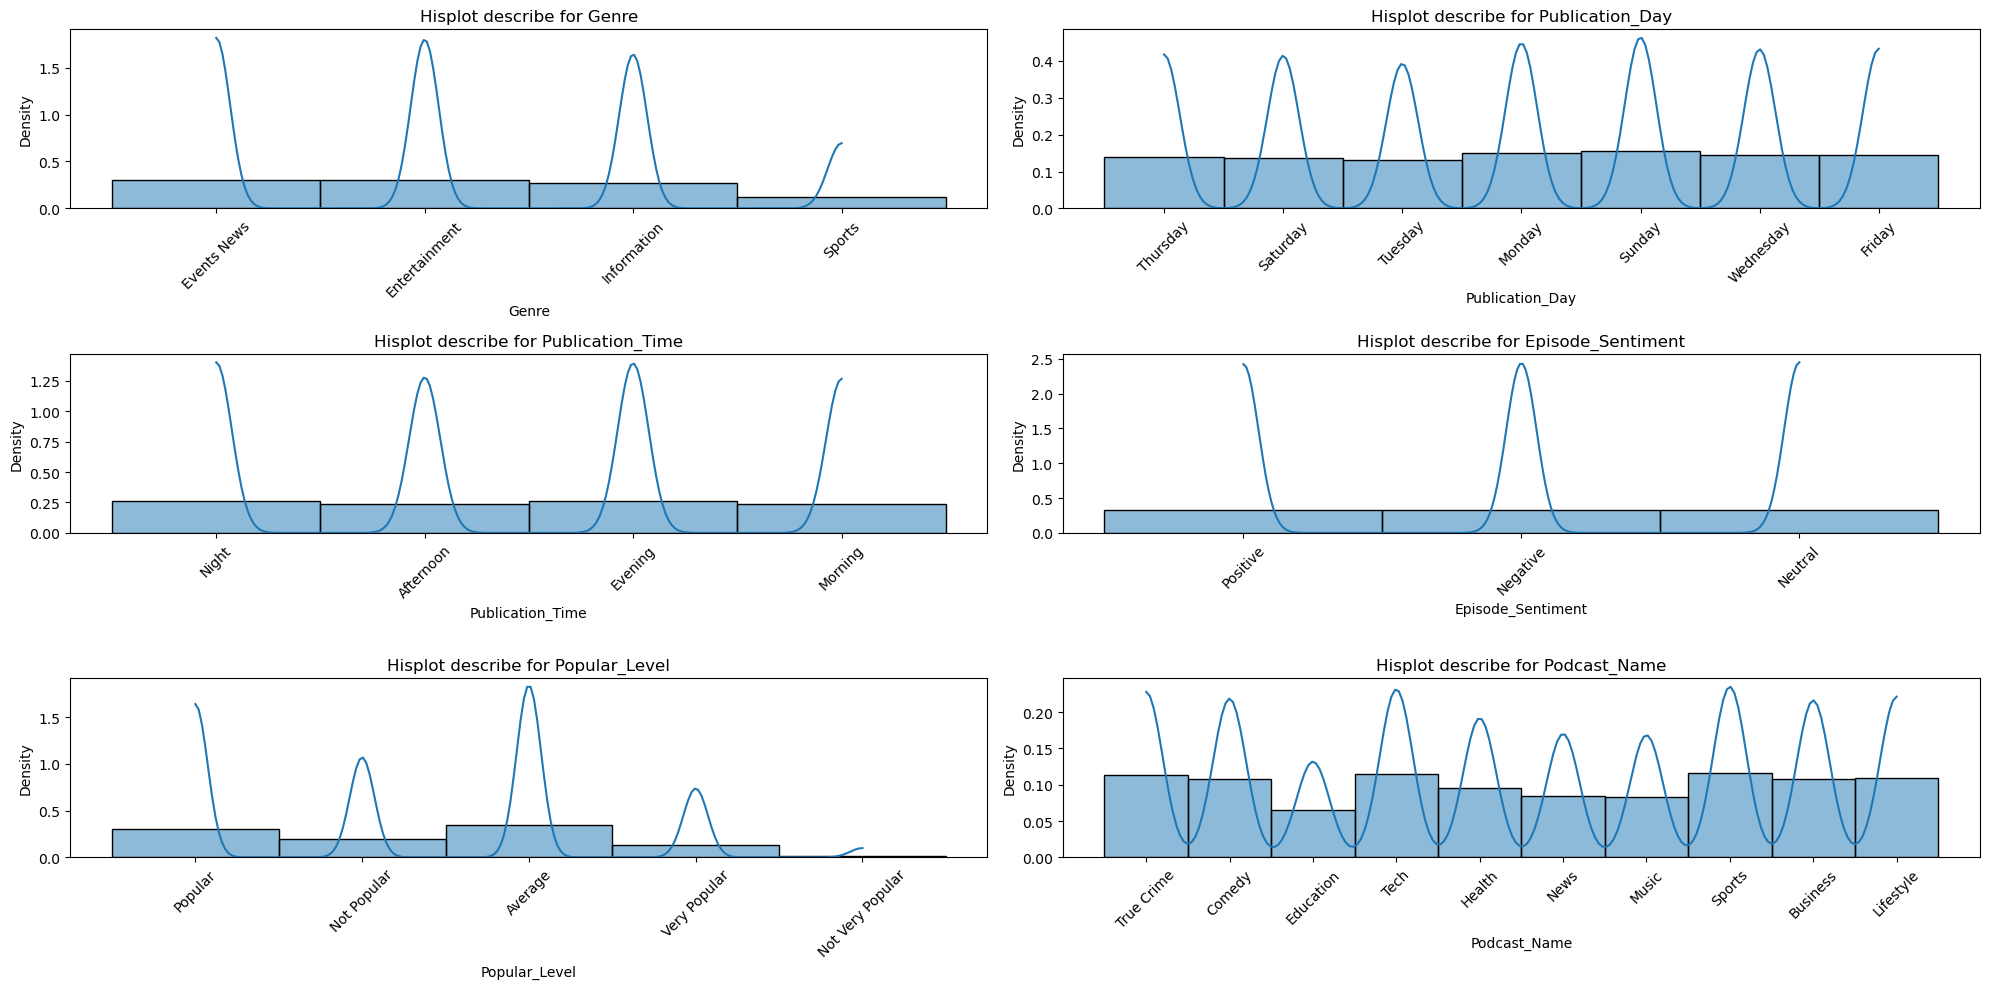

In [32]:
objects = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment', 'Popular_Level', 'Podcast_Name']
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
axes = axes.flatten()
for ax, i in zip(axes, objects):
    sns.histplot(data = df,x = i,ax = ax, kde=True, stat='density', bins=30)
    ax.set_title(f'Hisplot describe for {i}')
    ax.set_xlabel(i)
    for i in ax.get_xticklabels():
        i.set_rotation(45)
plt.tight_layout()
plt.show()

> Creating Boxplot and Countplot 

KeyboardInterrupt: 

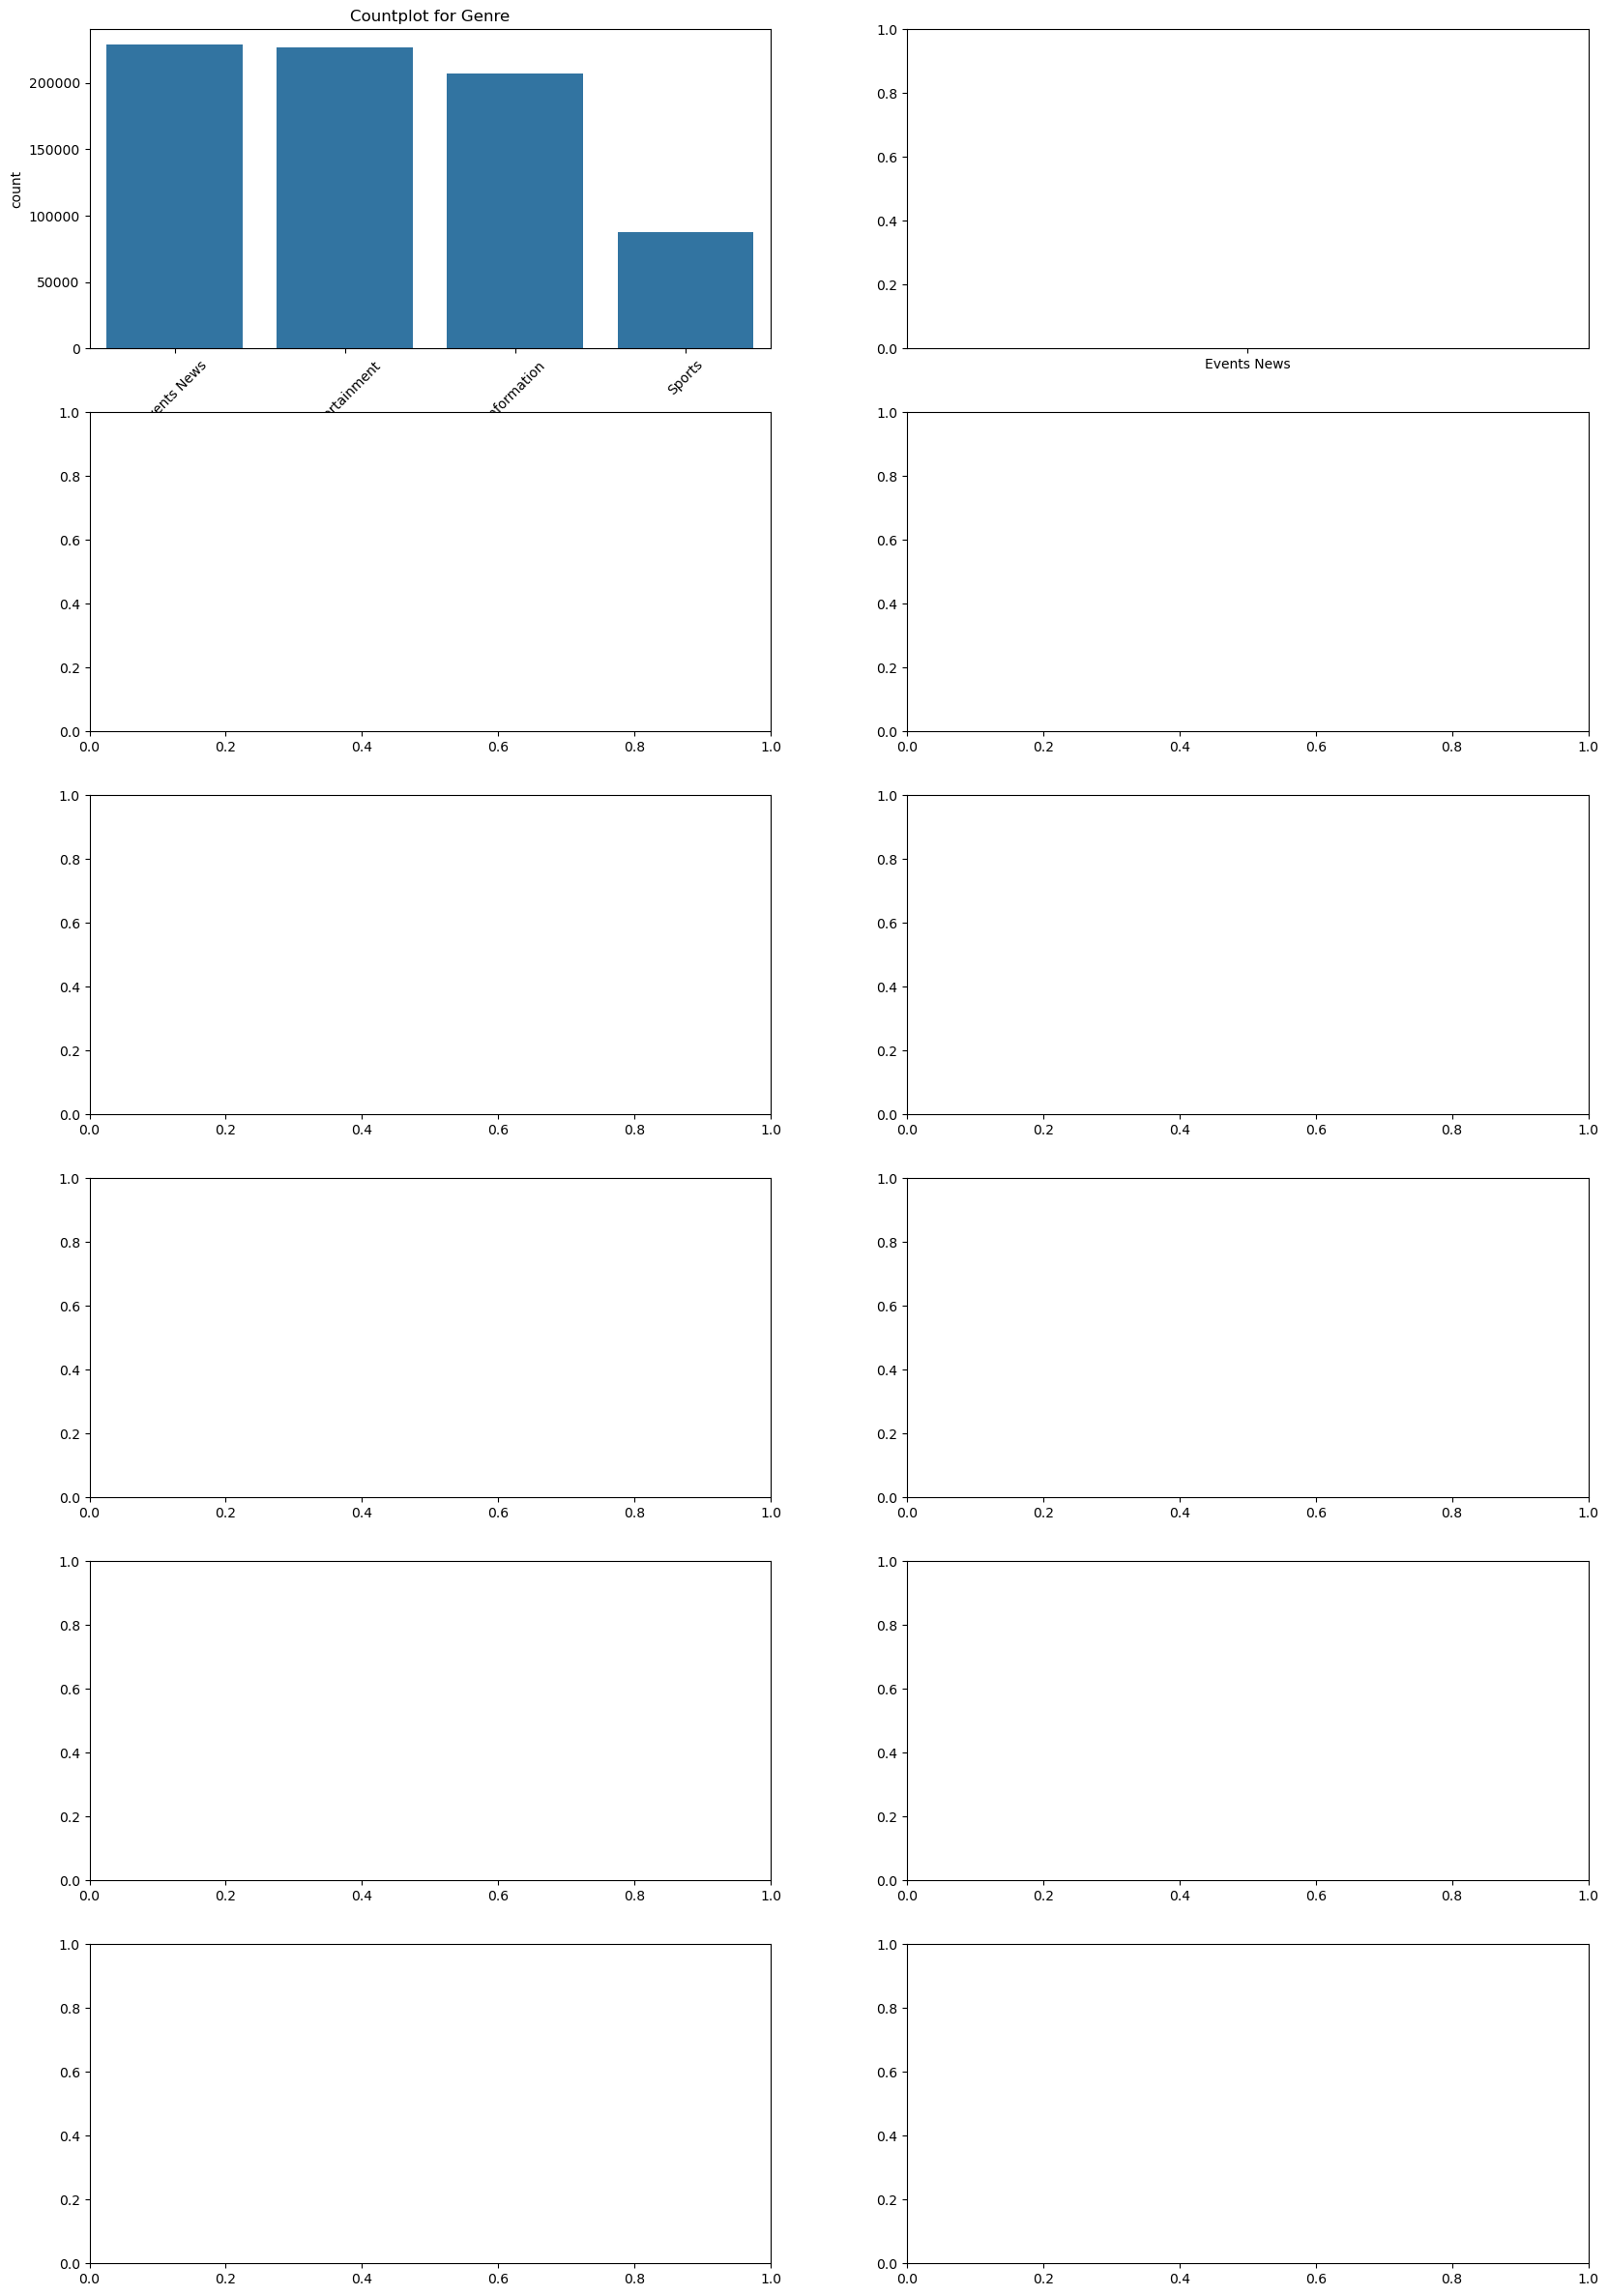

In [33]:
fig, axes = plt.subplots(6, 2, figsize=(20, 30)) 
axes = axes.flatten()

for idx, col in enumerate(objects):
    sns.countplot(data=df, x=col, ax=axes[2*idx])
    axes[2*idx].set_title(f'Countplot for {col}')
    axes[2*idx].set_xlabel(col)
    for label in axes[2*idx].get_xticklabels():
        label.set_rotation(45)
    
    sns.boxplot(data=df, x=col, y='Listening_Time_minutes', ax=axes[2*idx+1])
    axes[2*idx+1].set_title(f'Boxplot for {col} vs Listening_Time')
    axes[2*idx+1].set_xlabel(col)
    for label in axes[2*idx+1].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

# Data Preparation and Model 

In [56]:
mood = ['Negative', 'Neutral', 'Positive']
popularity = ['Not Very Popular','Not Popular','Average', 'Popular','Very Popular']
ord = OrdinalEncoder(categories=[mood, popularity])

columns_ordinal_encode = ['Episode_Sentiment', 'Popular_Level']
columns_label_encode = ['Genre', 'Publication_Day', 'Publication_Time', 'Podcast_Name']
num_cols = ['Episode_Length_minutes', 'Number_of_Ads', 'ratio_Ads', 'Episode_Title']


In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline 

In [64]:
preprocessing = ColumnTransformer([
    ('Ordinal', ord, columns_ordinal_encode),
    ('LabelEncoder', OrdinalEncoder(), columns_label_encode),
    ('StandardScale', StandardScaler(),num_cols)
])
input = [
    ('preprocess', preprocessing),
    ('model', Ridge())]
pipe = Pipeline(input)

In [65]:
pd.pandas.set_option("display.max_columns" , None)

In [ ]:
# X = df.drop(columns=['id', 'Listening_Time_minutes'])
# Y = df['Listening_Time_minutes']
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [66]:
df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Publication_Day,Publication_Time,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Popular_Level,ratio_Ads,Episode_Length_minutes+Episode_Title,Episode_Length_minutes+Publication_Time,Episode_Length_minutes+Number_of_Ads,Episode_Length_minutes+Episode_Sentiment,Episode_Length_minutes+Publication_Day,Episode_Length_minutes+Podcast_Name,Episode_Length_minutes+Genre,Episode_Length_minutes+Popular_Level,Episode_Title+Publication_Time,Episode_Title+Number_of_Ads,Episode_Title+Episode_Sentiment,Episode_Title+Publication_Day,Episode_Title+Podcast_Name,Episode_Title+Genre,Episode_Title+Popular_Level,Publication_Time+Number_of_Ads,Publication_Time+Episode_Sentiment,Publication_Time+Publication_Day,Publication_Time+Podcast_Name,Publication_Time+Genre,Publication_Time+Popular_Level,Number_of_Ads+Episode_Sentiment,Number_of_Ads+Publication_Day,Number_of_Ads+Podcast_Name,Number_of_Ads+Genre,Number_of_Ads+Popular_Level,Episode_Sentiment+Publication_Day,Episode_Sentiment+Podcast_Name,Episode_Sentiment+Genre,Episode_Sentiment+Popular_Level,Publication_Day+Podcast_Name,Publication_Day+Genre,Publication_Day+Popular_Level,Podcast_Name+Genre,Podcast_Name+Popular_Level,Genre+Popular_Level,Episode_Length_minutes+Episode_Title+Publication_Time,Episode_Length_minutes+Episode_Title+Number_of_Ads,Episode_Length_minutes+Episode_Title+Episode_Sentiment,Episode_Length_minutes+Episode_Title+Publication_Day,Episode_Length_minutes+Episode_Title+Podcast_Name,Episode_Length_minutes+Episode_Title+Genre,Episode_Length_minutes+Episode_Title+Popular_Level,Episode_Length_minutes+Publication_Time+Number_of_Ads,Episode_Length_minutes+Publication_Time+Episode_Sentiment,Episode_Length_minutes+Publication_Time+Publication_Day,Episode_Length_minutes+Publication_Time+Podcast_Name,Episode_Length_minutes+Publication_Time+Genre,Episode_Length_minutes+Publication_Time+Popular_Level,Episode_Length_minutes+Number_of_Ads+Episode_Sentiment,Episode_Length_minutes+Number_of_Ads+Publication_Day,Episode_Length_minutes+Number_of_Ads+Podcast_Name,Episode_Length_minutes+Number_of_Ads+Genre,Episode_Length_minutes+Number_of_Ads+Popular_Level,Episode_Length_minutes+Episode_Sentiment+Publication_Day,Episode_Length_minutes+Episode_Sentiment+Podcast_Name,Episode_Length_minutes+Episode_Sentiment+Genre,Episode_Length_minutes+Episode_Sentiment+Popular_Level,Episode_Length_minutes+Publication_Day+Podcast_Name,Episode_Length_minutes+Publication_Day+Genre,Episode_Length_minutes+Publication_Day+Popular_Level,Episode_Length_minutes+Podcast_Name+Genre,Episode_Length_minutes+Podcast_Name+Popular_Level,Episode_Length_minutes+Genre+Popular_Level,Episode_Title+Publication_Time+Number_of_Ads,Episode_Title+Publication_Time+Episode_Sentiment,Episode_Title+Publication_Time+Publication_Day,Episode_Title+Publication_Time+Podcast_Name,Episode_Title+Publication_Time+Genre,Episode_Title+Publication_Time+Popular_Level,Episode_Title+Number_of_Ads+Episode_Sentiment,Episode_Title+Number_of_Ads+Publication_Day,Episode_Title+Number_of_Ads+Podcast_Name,Episode_Title+Number_of_Ads+Genre,Episode_Title+Number_of_Ads+Popular_Level,Episode_Title+Episode_Sentiment+Publication_Day,Episode_Title+Episode_Sentiment+Podcast_Name,Episode_Title+Episode_Sentiment+Genre,Episode_Title+Episode_Sentiment+Popular_Level,Episode_Title+Publication_Day+Podcast_Name,Episode_Title+Publication_Day+Genre,Episode_Title+Publication_Day+Popular_Level,Episode_Title+Podcast_Name+Genre,Episode_Title+Podcast_Name+Popular_Level,Episode_Title+Genre+Popular_Level,Publication_Time+Number_of_Ads+Episode_Sentiment,Publication_Time+Number_of_Ads+Publication_Day,Publication_Time+Number_of_Ads+Podcast_Name,Publication_Time+Number_of_Ads+Genre,Publication_Time+Number_of_Ads+Popular_Level,Publication_Time+Episode_Sentiment+Publication_Day,Publication_Time+Episode_Sentiment+Podcast_Name,Publication_Time+Episode_Sentiment+Genre,Publication_Time+Episode_Sentiment+Popular_Level,Publication_Time+Publicatio

In [67]:
df_test

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Publication_Day,Publication_Time,Number_of_Ads,Episode_Sentiment,Popular_Level,ratio_Ads
0,750000,Education,73,78.96,Information,Saturday,Evening,1.0,Neutral,Average,0.012665
1,750001,Music,23,27.87,Entertainment,Sunday,Morning,0.0,Neutral,Popular,0.000000
2,750002,Comedy,11,69.10,Entertainment,Friday,Evening,0.0,Positive,Very Popular,0.000000
3,750003,Comedy,73,115.39,Entertainment,Sunday,Morning,2.0,Positive,Not Popular,0.017333
4,750004,Lifestyle,50,72.32,Entertainment,Wednesday,Morning,2.0,Neutral,Not Popular,0.027655
...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,Health,100,21.05,Information,Saturday,Evening,3.0,Negative,Very Popular,0.142518
249996,999996,Comedy,85,85.50,Entertainment,Saturday,Night,2.0,Negative,Not Popular,0.023392
249997,999997,Comedy,63,12.11,Entertainment,Thursday,Evening,1.0,Neutral,Average,0.082576
249998,999998,Business,46,113.46,Events News,Friday,Night,3.0,Positive,Popular,0.026441


In [ ]:
df['Popular_Level'].unique()

In [68]:
df_test.drop(columns=['id'] , inplace= True)
df.drop(columns= ['id'], inplace= True)

In [ ]:
common_cols = list(set(df.columns) & set(df_test.columns))
common_cols

# Train Test and Split

In [100]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
# common_cols = list(set(df.columns) & set(df_test.columns))
X_train_encoded = encoder.fit_transform(df_for_train)
# X_test_encoded = encoder.fit_transform(df_test[common_cols])

In [84]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
# common_cols = list(set(df.columns) & set(df_test.columns))
# X_train_encoded = encoder.fit_transform(df)
X_test_encoded = encoder.fit_transform(df_test)

In [103]:
X_train_encoded = pd.DataFrame(X_train_encoded)

In [85]:
X_test_encoded = pd.DataFrame(X_test_encoded)

In [86]:
X_test_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,2.0,72.0,7552.0,2.0,2.0,1.0,1.0,1.0,0.0,3744.0,144068.0,32770.0,32641.0,25665.0,50696.0,64337.0,32006.0,34420.0,281.0,286.0,211.0,492.0,702.0,282.0,350.0,6.0,4.0,9.0,12.0,6.0,5.0,4.0,9.0,12.0,6.0,5.0,9.0,12.0,6.0,5.0,22.0,10.0,10.0,9.0,10.0,10.0,164270.0,163749.0,161619.0,168535.0,171323.0,164890.0,165006.0,83364.0,71986.0,108144.0,121267.0,82018.0,84533.0,71370.0,106904.0,120510.0,81391.0,83695.0,96017.0,110576.0,70016.0,72552.0,139074.0,105768.0,107611.0,64598.0,120870.0,82171.0,1126.0,844.0,1969.0,2812.0,1126.0,1405.0,857.0,1998.0,2853.0,1143.0,1426.0,1479.0,2112.0,846.0,1055.0,4922.0,1970.0,2458.0,969.0,3499.0,1408.0,17.0,38.0,53.0,23.0,26.0,30.0,42.0,18.0,20.0,92.0,38.0,45.0,46.0,60.0,30.0,30.0,42.0,18.0,20.0,92.0,38.0,45.0,46.0,60.0,30.0,92.0,38.0,45.0,48.0,60.0,30.0,76.0,110.0,50.0,39.0,177465.0,183946.0,187646.0,180127.0,180424.0,181620.0,185176.0,178348.0,178635.0,192592.0,184421.0,184841.0,177631.0,188147.0,181011.0,181622.0,185202.0,178318.0,178605.0,192542.0,184420.0,184807.0,177644.0,188156.0,180987.0,190218.0,182181.0,182538.0,176222.0,185792.0,179244.0,181233.0,192899.0,185101.0,178560.0,163788.0,167546.0,157249.0,157588.0,172351.0,166749.0,166995.0,155824.0,170055.0,161366.0,171131.0,164586.0,164961.0,151322.0,168310.0,157800.0,163632.0,173332.0,167643.0,156287.0,171086.0,164364.0,164514.0,150906.0,168123.0,157268.0,163234.0,173243.0,167258.0,155928.0,160329.0,171874.0,164929.0,151298.0,164055.0,23573.0,33208.0,13480.0,15501.0,67723.0,30625.0,33363.0,11544.0,44832.0,19950.0,54681.0,23371.0,25880.0,8730.0,35417.0,15410.0,19951.0,68410.0,32798.0,13410.0,55045.0,23652.0,26232.0,8861.0,35773.0,15623.0,20235.0,69042.0,33172.0,13610.0,15076.0,55768.0,25589.0,10359.0,22209.0,1143.0,459.0,571.0,280.0,811.0,331.0,511.0,1855.0,750.0,387.0,434.0,1509.0,610.0,324.0,589.0,484.0,1508.0,610.0,374.0,627.0,608.0
1,5.0,22.0,2357.0,0.0,3.0,2.0,0.0,1.0,3.0,0.0,58266.0,13300.0,13204.0,10419.0,20484.0,26047.0,12957.0,13970.0,62.0,64.0,46.0,108.0,155.0,60.0,78.0,9.0,7.0,17.0,25.0,8.0,13.0,1.0,3.0,5.0,0.0,3.0,10.0,15.0,4.0,8.0,35.0,12.0,18.0,19.0,28.0,3.0,66353.0,66143.0,65351.0,67929.0,68953.0,66509.0,66619.0,33558.0,29160.0,43707.0,49183.0,33135.0,34182.0,28839.0,43145.0,48708.0,32736.0,33727.0,38880.0,44717.0,28199.0,29401.0,56308.0,42565.0,43498.0,26134.0,48965.0,33133.0,248.0,187.0,437.0,625.0,248.0,313.0,193.0,451.0,645.0,256.0,323.0,325.0,465.0,184.0,233.0,1085.0,432.0,543.0,197.0,774.0,303.0,26.0,60.0,86.0,33.0,44.0,52.0,75.0,28.0,38.0,175.0,68.0,88.0,89.0,128.0,43.0,10.0,15.0,4.0,8.0,35.0,12.0,18.0,17.0,28.0,3.0,105.0,40.0,53.0,57.0,78.0,23.0,116.0,178.0,63.0,79.0,69888.0,70334.0,70743.0,70351.0,70339.0,70250.0,70642.0,70222.0,70225.0,70869.0,70618.0,70607.0,70243.0,70938.0,70607.0,70244.0,70665.0,70214.0,70218.0,70884.0,70614.0,70606.0,70255.0,70948.0,70580.0,70817.0,70551.0,70538.0,70075.0,70865.0,70479.0,70561.0,71089.0,70858.0,70468.0,66218.0,67625.0,63521.0,63658.0,69305.0,67244.0,67323.0,63046.0,68544.0,65078.0,68919.0,66491.0,66649.0,61267.0,67949.0,63808.0,66074.0,69641.0,67577.0,63236.0,68893.0,66390.0,66467.0,60930.0

In [98]:
df_for_train = df.drop(columns = ['Listening_Time_minutes'], axis = 1 )

In [99]:
df_for_train

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Publication_Day,Publication_Time,Number_of_Ads,Episode_Sentiment,Popular_Level,ratio_Ads,Episode_Length_minutes+Episode_Title,Episode_Length_minutes+Publication_Time,Episode_Length_minutes+Number_of_Ads,Episode_Length_minutes+Episode_Sentiment,Episode_Length_minutes+Publication_Day,Episode_Length_minutes+Podcast_Name,Episode_Length_minutes+Genre,Episode_Length_minutes+Popular_Level,Episode_Title+Publication_Time,Episode_Title+Number_of_Ads,Episode_Title+Episode_Sentiment,Episode_Title+Publication_Day,Episode_Title+Podcast_Name,Episode_Title+Genre,Episode_Title+Popular_Level,Publication_Time+Number_of_Ads,Publication_Time+Episode_Sentiment,Publication_Time+Publication_Day,Publication_Time+Podcast_Name,Publication_Time+Genre,Publication_Time+Popular_Level,Number_of_Ads+Episode_Sentiment,Number_of_Ads+Publication_Day,Number_of_Ads+Podcast_Name,Number_of_Ads+Genre,Number_of_Ads+Popular_Level,Episode_Sentiment+Publication_Day,Episode_Sentiment+Podcast_Name,Episode_Sentiment+Genre,Episode_Sentiment+Popular_Level,Publication_Day+Podcast_Name,Publication_Day+Genre,Publication_Day+Popular_Level,Podcast_Name+Genre,Podcast_Name+Popular_Level,Genre+Popular_Level,Episode_Length_minutes+Episode_Title+Publication_Time,Episode_Length_minutes+Episode_Title+Number_of_Ads,Episode_Length_minutes+Episode_Title+Episode_Sentiment,Episode_Length_minutes+Episode_Title+Publication_Day,Episode_Length_minutes+Episode_Title+Podcast_Name,Episode_Length_minutes+Episode_Title+Genre,Episode_Length_minutes+Episode_Title+Popular_Level,Episode_Length_minutes+Publication_Time+Number_of_Ads,Episode_Length_minutes+Publication_Time+Episode_Sentiment,Episode_Length_minutes+Publication_Time+Publication_Day,Episode_Length_minutes+Publication_Time+Podcast_Name,Episode_Length_minutes+Publication_Time+Genre,Episode_Length_minutes+Publication_Time+Popular_Level,Episode_Length_minutes+Number_of_Ads+Episode_Sentiment,Episode_Length_minutes+Number_of_Ads+Publication_Day,Episode_Length_minutes+Number_of_Ads+Podcast_Name,Episode_Length_minutes+Number_of_Ads+Genre,Episode_Length_minutes+Number_of_Ads+Popular_Level,Episode_Length_minutes+Episode_Sentiment+Publication_Day,Episode_Length_minutes+Episode_Sentiment+Podcast_Name,Episode_Length_minutes+Episode_Sentiment+Genre,Episode_Length_minutes+Episode_Sentiment+Popular_Level,Episode_Length_minutes+Publication_Day+Podcast_Name,Episode_Length_minutes+Publication_Day+Genre,Episode_Length_minutes+Publication_Day+Popular_Level,Episode_Length_minutes+Podcast_Name+Genre,Episode_Length_minutes+Podcast_Name+Popular_Level,Episode_Length_minutes+Genre+Popular_Level,Episode_Title+Publication_Time+Number_of_Ads,Episode_Title+Publication_Time+Episode_Sentiment,Episode_Title+Publication_Time+Publication_Day,Episode_Title+Publication_Time+Podcast_Name,Episode_Title+Publication_Time+Genre,Episode_Title+Publication_Time+Popular_Level,Episode_Title+Number_of_Ads+Episode_Sentiment,Episode_Title+Number_of_Ads+Publication_Day,Episode_Title+Number_of_Ads+Podcast_Name,Episode_Title+Number_of_Ads+Genre,Episode_Title+Number_of_Ads+Popular_Level,Episode_Title+Episode_Sentiment+Publication_Day,Episode_Title+Episode_Sentiment+Podcast_Name,Episode_Title+Episode_Sentiment+Genre,Episode_Title+Episode_Sentiment+Popular_Level,Episode_Title+Publication_Day+Podcast_Name,Episode_Title+Publication_Day+Genre,Episode_Title+Publication_Day+Popular_Level,Episode_Title+Podcast_Name+Genre,Episode_Title+Podcast_Name+Popular_Level,Episode_Title+Genre+Popular_Level,Publication_Time+Number_of_Ads+Episode_Sentiment,Publication_Time+Number_of_Ads+Publication_Day,Publication_Time+Number_of_Ads+Podcast_Name,Publication_Time+Number_of_Ads+Genre,Publication_Time+Number_of_Ads+Popular_Level,Publication_Time+Episode_Sentiment+Publication_Day,Publication_Time+Episode_Sentiment+Podcast_Name,Publication_Time+Episode_Sentiment+Genre,Publication_Time+Episode_Sentiment+Popular_Level,Publication_Time+Publication_Day+Podcast_Name,Publica

In [95]:
df_test

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Publication_Day,Publication_Time,Number_of_Ads,Episode_Sentiment,Popular_Level,ratio_Ads,Episode_Length_minutes+Episode_Title,Episode_Length_minutes+Publication_Time,Episode_Length_minutes+Number_of_Ads,Episode_Length_minutes+Episode_Sentiment,Episode_Length_minutes+Publication_Day,Episode_Length_minutes+Podcast_Name,Episode_Length_minutes+Genre,Episode_Length_minutes+Popular_Level,Episode_Title+Publication_Time,Episode_Title+Number_of_Ads,Episode_Title+Episode_Sentiment,Episode_Title+Publication_Day,Episode_Title+Podcast_Name,Episode_Title+Genre,Episode_Title+Popular_Level,Publication_Time+Number_of_Ads,Publication_Time+Episode_Sentiment,Publication_Time+Publication_Day,Publication_Time+Podcast_Name,Publication_Time+Genre,Publication_Time+Popular_Level,Number_of_Ads+Episode_Sentiment,Number_of_Ads+Publication_Day,Number_of_Ads+Podcast_Name,Number_of_Ads+Genre,Number_of_Ads+Popular_Level,Episode_Sentiment+Publication_Day,Episode_Sentiment+Podcast_Name,Episode_Sentiment+Genre,Episode_Sentiment+Popular_Level,Publication_Day+Podcast_Name,Publication_Day+Genre,Publication_Day+Popular_Level,Podcast_Name+Genre,Podcast_Name+Popular_Level,Genre+Popular_Level,Episode_Length_minutes+Episode_Title+Publication_Time,Episode_Length_minutes+Episode_Title+Number_of_Ads,Episode_Length_minutes+Episode_Title+Episode_Sentiment,Episode_Length_minutes+Episode_Title+Publication_Day,Episode_Length_minutes+Episode_Title+Podcast_Name,Episode_Length_minutes+Episode_Title+Genre,Episode_Length_minutes+Episode_Title+Popular_Level,Episode_Length_minutes+Publication_Time+Number_of_Ads,Episode_Length_minutes+Publication_Time+Episode_Sentiment,Episode_Length_minutes+Publication_Time+Publication_Day,Episode_Length_minutes+Publication_Time+Podcast_Name,Episode_Length_minutes+Publication_Time+Genre,Episode_Length_minutes+Publication_Time+Popular_Level,Episode_Length_minutes+Number_of_Ads+Episode_Sentiment,Episode_Length_minutes+Number_of_Ads+Publication_Day,Episode_Length_minutes+Number_of_Ads+Podcast_Name,Episode_Length_minutes+Number_of_Ads+Genre,Episode_Length_minutes+Number_of_Ads+Popular_Level,Episode_Length_minutes+Episode_Sentiment+Publication_Day,Episode_Length_minutes+Episode_Sentiment+Podcast_Name,Episode_Length_minutes+Episode_Sentiment+Genre,Episode_Length_minutes+Episode_Sentiment+Popular_Level,Episode_Length_minutes+Publication_Day+Podcast_Name,Episode_Length_minutes+Publication_Day+Genre,Episode_Length_minutes+Publication_Day+Popular_Level,Episode_Length_minutes+Podcast_Name+Genre,Episode_Length_minutes+Podcast_Name+Popular_Level,Episode_Length_minutes+Genre+Popular_Level,Episode_Title+Publication_Time+Number_of_Ads,Episode_Title+Publication_Time+Episode_Sentiment,Episode_Title+Publication_Time+Publication_Day,Episode_Title+Publication_Time+Podcast_Name,Episode_Title+Publication_Time+Genre,Episode_Title+Publication_Time+Popular_Level,Episode_Title+Number_of_Ads+Episode_Sentiment,Episode_Title+Number_of_Ads+Publication_Day,Episode_Title+Number_of_Ads+Podcast_Name,Episode_Title+Number_of_Ads+Genre,Episode_Title+Number_of_Ads+Popular_Level,Episode_Title+Episode_Sentiment+Publication_Day,Episode_Title+Episode_Sentiment+Podcast_Name,Episode_Title+Episode_Sentiment+Genre,Episode_Title+Episode_Sentiment+Popular_Level,Episode_Title+Publication_Day+Podcast_Name,Episode_Title+Publication_Day+Genre,Episode_Title+Publication_Day+Popular_Level,Episode_Title+Podcast_Name+Genre,Episode_Title+Podcast_Name+Popular_Level,Episode_Title+Genre+Popular_Level,Publication_Time+Number_of_Ads+Episode_Sentiment,Publication_Time+Number_of_Ads+Publication_Day,Publication_Time+Number_of_Ads+Podcast_Name,Publication_Time+Number_of_Ads+Genre,Publication_Time+Number_of_Ads+Popular_Level,Publication_Time+Episode_Sentiment+Publication_Day,Publication_Time+Episode_Sentiment+Podcast_Name,Publication_Time+Episode_Sentiment+Genre,Publication_Time+Episode_Sentiment+Popular_Level,Publication_Time+Publication_Day+Podcast_Name,Publica

In [104]:
X_train_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,9.0,97.0,NaN,1.0,4.0,3.0,0.0,2.0,3.0,NaN,401594.0,45721.0,45620.0,34857.0,76417.0,104548.0,45330.0,51484.0,391.0,401.0,293.0,683.0,979.0,389.0,488.0,21.0,11.0,25.0,39.0,13.0,18.0,2.0,4.0,9.0,1.0,3.0,18.0,29.0,9.0,13.0,49.0,17.0,23.0,37.0,48.0,8.0,544489.0,541606.0,523063.0,576952.0,596954.0,545518.0,547094.0,152200.0,121747.0,227633.0,281577.0,149471.0,158846.0,121167.0,225937.0,279301.0,148481.0,157774.0,187322.0,237827.0,119261.0,128140.0,369498.0,222252.0,231304.0,105515.0,283314.0,155287.0,1573.0,1175.0,2741.0,3919.0,1565.0,1958.0,1187.0,2757.0,3938.0,1578.0,1972.0,2055.0,2939.0,1173.0,1468.0,6839.0,2733.0,3418.0,1817.0,4898.0,1948.0,47.0,97.0,138.0,58.0,72.0,81.0,119.0,45.0,58.0,259.0,101.0,128.0,156.0,198.0,68.0,18.0,29.0,9.0,13.0,49.0,17.0,23.0,37.0,48.0,8.0,189.0,73.0,93.0,116.0,148.0,48.0,189.0,248.0,88.0,171.0,625051.0,640187.0,652522.0,635632.0,636303.0,635803.0,647311.0,631629.0,632148.0,665782.0,645893.0,646987.0,630341.0,657885.0,641384.0,635414.0,647212.0,631034.0,631568.0,665961.0,645762.0,646735.0,629868.0,657835.0,641037.0,659324.0,641346.0,642158.0,625480.0,652691.0,636856.0,639924.0,670587.0,651302.0,635460.0,538687.0,566670.0,487838.0,491434.0,604212.0,559494.0,561050.0,476087.0,585389.0,517384.0,596182.0,542262.0,544238.0,444196.0,571756.0,491361.0,534129.0,609896.0,564296.0,478855.0,594640.0,540325.0,541919.0,441264.0,569205.0,488203.0,531864.0,607888.0,561938.0,475956.0,509158.0,600086.0,544137.0,444247.0,535721.0,32871.0,46954.0,18786.0,23079.0,108812.0,43791.0,51163.0,16720.0,70880.0,30103.0,82168.0,32912.0,39245.0,12796.0,54572.0,22946.0,28484.0,117973.0,50908.0,20435.0,82372.0,33005.0,39370.0,12843.0,54681.0,23002.0,28582.0,118220.0,51067.0,20484.0,21609.0,91092.0,38970.0,15647.0,34063.0,2718.0,1090.0,1362.0,975.0,1957.0,777.0,1603.0,4457.0,1777.0,1277.0,1628.0,4098.0,1628.0,1306.0,2122.0,464.0,948.0,368.0,372.0,480.0,1704.0
1,1.0,25.0,12241.0,0.0,2.0,0.0,2.0,0.0,3.0,5996.0,79263.0,8563.0,8523.0,6500.0,14440.0,19857.0,8485.0,9692.0,72.0,81.0,54.0,128.0,181.0,72.0,93.0,4.0,0.0,2.0,1.0,0.0,3.0,12.0,22.0,27.0,14.0,19.0,2.0,1.0,0.0,3.0,21.0,8.0,13.0,4.0,8.0,3.0,109124.0,108081.0,104631.0,115837.0,119952.0,109134.0,109519.0,28967.0,23188.0,43869.0,54594.0,28438.0,30501.0,22912.0,43146.0,53677.0,28096.0,30022.0,36068.0,45928.0,22653.0,24494.0,72680.0,42802.0,44767.0,20022.0,55323.0,29756.0,293.0,216.0,506.0,721.0,288.0,363.0,237.0,551.0,784.0,315.0,396.0,380.0,541.0,216.0,273.0,1281.0,512.0,643.0,322.0,908.0,363.0,8.0,18.0,23.0,10.0,15.0,2.0,1.0,0.0,3.0,21.0,8.0,13.0,4.0,8.0,3.0,50.0,67.0,30.0,39.0,167.0,70.0,89.0,90.0,114.0,49.0,21.0,8.0,13.0,4.0,8.0,3.0,81.0,108.0,43.0,20.0,125132.0,126866.0,128450.0,126819.0,126740.0,126674.0,128224.0,126411.0,126426.0,129132.0,128025.0,128084.0,126316.0,129347.0,127838.0,126482.0,128157.0,126255.0,126205.0,129111.0,127941.0,127907.0,126084.0,129268.0,127650.0,128958.0,127723.0,127675.0,125585.0,129110.0,127266.0,127589.0,129961.0,128914.0,127115.0,107923.0,113672.0,96671.0,97593.0,121698.0,111997.0,112421.0,94178.0,117540.0,102806.0,120305.0,108669.0,109396.0,87883.0,1

In [105]:
X_train_encoded.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
count,750000.000000,750000.000000,662907.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,662906.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.00000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.0000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,75

In [106]:
x_train, x_test , y_train, y_test = tts(X_train_encoded, df['Listening_Time_minutes'], test_size=0.2 , random_state = 0)

x_train, x_val , y_train , y_val = tts(x_train , y_train , test_size = 0.2 , random_state = 0)

In [107]:
x_train.shape , x_test.shape , x_val.shape

((480000, 256), (150000, 256), (120000, 256))

In [108]:
xgb_model

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(alpha=92.93636363636362, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [109]:
from sklearn.metrics import root_mean_squared_error
baseline_model = XGBRegressor(random_state = 42)
baseline_model.fit(x_train , y_train , eval_set = [(x_val , y_val)], verbose = False)
val_pred = baseline_model.predict(x_val)

baseline_rmse = root_mean_squared_error(y_val , val_pred )

baseline_rmse

13.171929671909602

In [110]:
pd.DataFrame(val_pred)

,0
0,17.835951
1,40.387352
2,51.969677
3,38.330921
4,8.855066
...,...
119995,49.021156
119996,74.869461
119997,19.553392
119998,54.175583


In [111]:
y_val

585462     9.90520
222122    54.66792
368318    55.19004
638733    34.62108
719237     7.77312
            ...   
531457    10.52000
612958    60.10883
121656    17.89000
700002    54.67284
28184     64.86219
Name: Listening_Time_minutes, Length: 120000, dtype: float64

In [ ]:
# import math
# math.square(baseline_rmse)

In [112]:
#initial tuning

xgb_model = XGBRegressor(
    max_depth = 3,
    min_child_weight = 1,
    learning_rate = 0.1,
    n_estimators = 300,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42
)

#train and evaluate
val_score =xgb_model.fit(x_train, y_train,
              eval_set = [(x_val , y_val)],
              verbose = True)
data = val_score

[0]	validation_0-rmse:47.67413
[1]	validation_0-rmse:43.32611
[2]	validation_0-rmse:39.44840
[3]	validation_0-rmse:36.00250
[4]	validation_0-rmse:32.94407
[5]	validation_0-rmse:30.23812
[6]	validation_0-rmse:27.85232
[7]	validation_0-rmse:25.81800
[8]	validation_0-rmse:24.03871
[9]	validation_0-rmse:22.41788
[10]	validation_0-rmse:21.01591
[11]	validation_0-rmse:19.79973
[12]	validation_0-rmse:18.75555
[13]	validation_0-rmse:17.90466
[14]	validation_0-rmse:17.13848
[15]	validation_0-rmse:16.48868
[16]	validation_0-rmse:15.94239
[17]	validation_0-rmse:15.48222
[18]	validation_0-rmse:15.09664
[19]	validation_0-rmse:14.77775
[20]	validation_0-rmse:14.51019
[21]	validation_0-rmse:14.30275
[22]	validation_0-rmse:14.11584
[23]	validation_0-rmse:13.96313
[24]	validation_0-rmse:13.83809
[25]	validation_0-rmse:13.73544
[26]	validation_0-rmse:13.65098
[27]	validation_0-rmse:13.57968
[28]	validation_0-rmse:13.52170
[29]	validation_0-rmse:13.47769
[30]	validation_0-rmse:13.43638
[31]	validation_0-

In [ ]:
data

In [ ]:
#Grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth' : [3,5,7],
    'min_child_weight' : [1,3,5],
    # 'lambda' : [1, 1.5]
    'reg_alpha': np.linspace(20,100,20)
    
}

grid_search = GridSearchCV(estimator = xgb_model,
                           param_grid= param_grid,
                           scoring = 'neg_mean_squared_error',
                           cv = 3,
                           verbose = 1)

grid_search.fit(x_train ,y_train)

diccc = grid_search.best_params_


In [ ]:
diccc

In [89]:
#initial tuning

xgb_model = XGBRegressor(
    alpha = 92.93636363636362,
    max_depth = 3,
    min_child_weight = 3,
    learning_rate = 0.1,
    n_estimators = 300,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    
)

#train and evaluate
val_score =xgb_model.fit(x_train, y_train,
              eval_set = [(x_val , y_val)],
              verbose = True)
data = val_score

[0]	validation_0-rmse:47.67430
[1]	validation_0-rmse:42.94073
[2]	validation_0-rmse:39.03072
[3]	validation_0-rmse:35.16751
[4]	validation_0-rmse:32.04006
[5]	validation_0-rmse:28.88544
[6]	validation_0-rmse:26.04720
[7]	validation_0-rmse:23.88859
[8]	validation_0-rmse:21.98036
[9]	validation_0-rmse:19.85984
[10]	validation_0-rmse:17.95707
[11]	validation_0-rmse:16.25181
[12]	validation_0-rmse:14.71734
[13]	validation_0-rmse:13.34579
[14]	validation_0-rmse:12.10973
[15]	validation_0-rmse:10.99956
[16]	validation_0-rmse:10.23638
[17]	validation_0-rmse:9.32733
[18]	validation_0-rmse:8.51201
[19]	validation_0-rmse:7.99357
[20]	validation_0-rmse:7.33238
[21]	validation_0-rmse:6.72930
[22]	validation_0-rmse:6.17869
[23]	validation_0-rmse:5.70004
[24]	validation_0-rmse:5.43453
[25]	validation_0-rmse:5.20861
[26]	validation_0-rmse:4.82637
[27]	validation_0-rmse:4.48404
[28]	validation_0-rmse:4.17488
[29]	validation_0-rmse:3.90926
[30]	validation_0-rmse:3.67250
[31]	validation_0-rmse:3.57986
[

In [ ]:
predd = xgb_model.predict(x_test)
rmse_score = mean_squared_error(y_test , predd)
rmse_score

In [ ]:
#Random Search

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'max_depth':[6,7,9,10,11,12],
    'min_child_weight': range(5,30),
    'learning_rate':np.linspace(0.001,0.1,10),
    'alpha' : np.linspace(0.1,100 ,100)
}

random_search = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions = param_distributions,
    n_iter = 50,
    scoring = 'neg_mean_squared_error',
    cv = 3 ,
    verbose = 1,
    random_state = 42
)

# random_search.fit(x_train,y_train)

random_search.best_params_

In [ ]:
# Checking for those values 
from xgboost import callback

xgb_model = XGBRegressor(
    max_depth = 6,
    min_child_weight = 29 ,
    learning_rate = 0.023000000000000003,
    n_estimators = 300,
    subsample = 0.8,
    colsample_bytree = 1,
    random_state = 42,
    alpha = 84.86363636363636
    # max_depth = 4, min_child_weight = 3.954410954734405, learning_rate = 0.01565143556208564, subsample = 0.7136407505597232, colsample_bytree = 0.9875741022106798
)

# evals_result = {}

#train and evaluate
val_score =xgb_model.fit(x_train, y_train,
              eval_set = [(x_val , y_val)],
              # early_stopping_rounds=10,
            #   callbacks=[callback.EarlyStopping(rounds=10, save_best=True)],
              verbose = True
              
              )

# # eval_results = xgb_model.evals_result()

# # data = eval_results['rmse']

In [ ]:
xgb_model

In [ ]:
# Checking for those values 
from xgboost import callback

xgb_model = XGBRegressor(
    max_depth = rand_dic['max_depth'],
    min_child_weight = rand_dic['min_child_weight'],
    learning_rate = rand_dic['learning_rate'],
    n_estimators = 300,
    subsample = 0.8,
    colsample_bytree = 1,
    random_state = 42,
    alpha = rand_dic['alpha']
    # max_depth = 4, min_child_weight = 3.954410954734405, learning_rate = 0.01565143556208564, subsample = 0.7136407505597232, colsample_bytree = 0.9875741022106798
)

# evals_result = {}

#train and evaluate
val_score =xgb_model.fit(x_train, y_train,
              eval_set = [(x_val , y_val)],
              # early_stopping_rounds=10,
            #   callbacks=[callback.EarlyStopping(rounds=10, save_best=True)],
              verbose = True
              
              )

# # eval_results = xgb_model.evals_result()

# # data = eval_results['rmse']


In [91]:
predd = xgb_model.predict(x_test)
rmse_score = mean_squared_error(y_test , predd)
rmse_score

0.1453753998011882

In [92]:
X_train_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256
0,9.0,97.0,NaN,1.0,4.0,3.0,0.0,2.0,13983.0,3.0,NaN,401594.0,45721.0,45620.0,34857.0,76417.0,104548.0,45330.0,51484.0,391.0,401.0,293.0,683.0,979.0,389.0,488.0,21.0,11.0,25.0,39.0,13.0,18.0,2.0,4.0,9.0,1.0,3.0,18.0,29.0,9.0,13.0,49.0,17.0,23.0,37.0,48.0,8.0,544489.0,541606.0,523063.0,576952.0,596954.0,545518.0,547094.0,152200.0,121747.0,227633.0,281577.0,149471.0,158846.0,121167.0,225937.0,279301.0,148481.0,157774.0,187322.0,237827.0,119261.0,128140.0,369498.0,222252.0,231304.0,105515.0,283314.0,155287.0,1573.0,1175.0,2741.0,3919.0,1565.0,1958.0,1187.0,2757.0,3938.0,1578.0,1972.0,2055.0,2939.0,1173.0,1468.0,6839.0,2733.0,3418.0,1817.0,4898.0,1948.0,47.0,97.0,138.0,58.0,72.0,81.0,119.0,45.0,58.0,259.0,101.0,128.0,156.0,198.0,68.0,18.0,29.0,9.0,13.0,49.0,17.0,23.0,37.0,48.0,8.0,189.0,73.0,93.0,116.0,148.0,48.0,189.0,248.0,88.0,171.0,625051.0,640187.0,652522.0,635632.0,636303.0,635803.0,647311.0,631629.0,632148.0,665782.0,645893.0,646987.0,630341.0,657885.0,641384.0,635414.0,647212.0,631034.0,631568.0,665961.0,645762.0,646735.0,629868.0,657835.0,641037.0,659324.0,641346.0,642158.0,625480.0,652691.0,636856.0,639924.0,670587.0,651302.0,635460.0,538687.0,566670.0,487838.0,491434.0,604212.0,559494.0,561050.0,476087.0,585389.0,517384.0,596182.0,542262.0,544238.0,444196.0,571756.0,491361.0,534129.0,609896.0,564296.0,478855.0,594640.0,540325.0,541919.0,441264.0,569205.0,488203.0,531864.0,607888.0,561938.0,475956.0,509158.0,600086.0,544137.0,444247.0,535721.0,32871.0,46954.0,18786.0,23079.0,108812.0,43791.0,51163.0,16720.0,70880.0,30103.0,82168.0,32912.0,39245.0,12796.0,54572.0,22946.0,28484.0,117973.0,50908.0,20435.0,82372.0,33005.0,39370.0,12843.0,54681.0,23002.0,28582.0,118220.0,51067.0,20484.0,21609.0,91092.0,38970.0,15647.0,34063.0,2718.0,1090.0,1362.0,975.0,1957.0,777.0,1603.0,4457.0,1777.0,1277.0,1628.0,4098.0,1628.0,1306.0,2122.0,464.0,948.0,368.0,372.0,480.0,1704.0
1,1.0,25.0,12241.0,0.0,2.0,0.0,2.0,0.0,39444.0,3.0,5996.0,79263.0,8563.0,8523.0,6500.0,14440.0,19857.0,8485.0,9692.0,72.0,81.0,54.0,128.0,181.0,72.0,93.0,4.0,0.0,2.0,1.0,0.0,3.0,12.0,22.0,27.0,14.0,19.0,2.0,1.0,0.0,3.0,21.0,8.0,13.0,4.0,8.0,3.0,109124.0,108081.0,104631.0,115837.0,119952.0,109134.0,109519.0,28967.0,23188.0,43869.0,54594.0,28438.0,30501.0,22912.0,43146.0,53677.0,28096.0,30022.0,36068.0,45928.0,22653.0,24494.0,72680.0,42802.0,44767.0,20022.0,55323.0,29756.0,293.0,216.0,506.0,721.0,288.0,363.0,237.0,551.0,784.0,315.0,396.0,380.0,541.0,216.0,273.0,1281.0,512.0,643.0,322.0,908.0,363.0,8.0,18.0,23.0,10.0,15.0,2.0,1.0,0.0,3.0,21.0,8.0,13.0,4.0,8.0,3.0,50.0,67.0,30.0,39.0,167.0,70.0,89.0,90.0,114.0,49.0,21.0,8.0,13.0,4.0,8.0,3.0,81.0,108.0,43.0,20.0,125132.0,126866.0,128450.0,126819.0,126740.0,126674.0,128224.0,126411.0,126426.0,129132.0,128025.0,128084.0,126316.0,129347.0,127838.0,126482.0,128157.0,126255.0,126205.0,129111.0,127941.0,127907.0,126084.0,129268.0,127650.0,128958.0,127723.0,127675.0,125585.0,129110.0,127266.0,127589.0,129961.0,128914.0,127115.0,107923.0,113672.0,96671.0,97593.0,121698.0,111997.0,112421.0,94178.0,117540.0,102806.0,120305.0,108669.

In [93]:
X_test_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,2.0,72.0,7552.0,2.0,2.0,1.0,1.0,1.0,0.0,3744.0,144068.0,32770.0,32641.0,25665.0,50696.0,64337.0,32006.0,34420.0,281.0,286.0,211.0,492.0,702.0,282.0,350.0,6.0,4.0,9.0,12.0,6.0,5.0,4.0,9.0,12.0,6.0,5.0,9.0,12.0,6.0,5.0,22.0,10.0,10.0,9.0,10.0,10.0,164270.0,163749.0,161619.0,168535.0,171323.0,164890.0,165006.0,83364.0,71986.0,108144.0,121267.0,82018.0,84533.0,71370.0,106904.0,120510.0,81391.0,83695.0,96017.0,110576.0,70016.0,72552.0,139074.0,105768.0,107611.0,64598.0,120870.0,82171.0,1126.0,844.0,1969.0,2812.0,1126.0,1405.0,857.0,1998.0,2853.0,1143.0,1426.0,1479.0,2112.0,846.0,1055.0,4922.0,1970.0,2458.0,969.0,3499.0,1408.0,17.0,38.0,53.0,23.0,26.0,30.0,42.0,18.0,20.0,92.0,38.0,45.0,46.0,60.0,30.0,30.0,42.0,18.0,20.0,92.0,38.0,45.0,46.0,60.0,30.0,92.0,38.0,45.0,48.0,60.0,30.0,76.0,110.0,50.0,39.0,177465.0,183946.0,187646.0,180127.0,180424.0,181620.0,185176.0,178348.0,178635.0,192592.0,184421.0,184841.0,177631.0,188147.0,181011.0,181622.0,185202.0,178318.0,178605.0,192542.0,184420.0,184807.0,177644.0,188156.0,180987.0,190218.0,182181.0,182538.0,176222.0,185792.0,179244.0,181233.0,192899.0,185101.0,178560.0,163788.0,167546.0,157249.0,157588.0,172351.0,166749.0,166995.0,155824.0,170055.0,161366.0,171131.0,164586.0,164961.0,151322.0,168310.0,157800.0,163632.0,173332.0,167643.0,156287.0,171086.0,164364.0,164514.0,150906.0,168123.0,157268.0,163234.0,173243.0,167258.0,155928.0,160329.0,171874.0,164929.0,151298.0,164055.0,23573.0,33208.0,13480.0,15501.0,67723.0,30625.0,33363.0,11544.0,44832.0,19950.0,54681.0,23371.0,25880.0,8730.0,35417.0,15410.0,19951.0,68410.0,32798.0,13410.0,55045.0,23652.0,26232.0,8861.0,35773.0,15623.0,20235.0,69042.0,33172.0,13610.0,15076.0,55768.0,25589.0,10359.0,22209.0,1143.0,459.0,571.0,280.0,811.0,331.0,511.0,1855.0,750.0,387.0,434.0,1509.0,610.0,324.0,589.0,484.0,1508.0,610.0,374.0,627.0,608.0
1,5.0,22.0,2357.0,0.0,3.0,2.0,0.0,1.0,3.0,0.0,58266.0,13300.0,13204.0,10419.0,20484.0,26047.0,12957.0,13970.0,62.0,64.0,46.0,108.0,155.0,60.0,78.0,9.0,7.0,17.0,25.0,8.0,13.0,1.0,3.0,5.0,0.0,3.0,10.0,15.0,4.0,8.0,35.0,12.0,18.0,19.0,28.0,3.0,66353.0,66143.0,65351.0,67929.0,68953.0,66509.0,66619.0,33558.0,29160.0,43707.0,49183.0,33135.0,34182.0,28839.0,43145.0,48708.0,32736.0,33727.0,38880.0,44717.0,28199.0,29401.0,56308.0,42565.0,43498.0,26134.0,48965.0,33133.0,248.0,187.0,437.0,625.0,248.0,313.0,193.0,451.0,645.0,256.0,323.0,325.0,465.0,184.0,233.0,1085.0,432.0,543.0,197.0,774.0,303.0,26.0,60.0,86.0,33.0,44.0,52.0,75.0,28.0,38.0,175.0,68.0,88.0,89.0,128.0,43.0,10.0,15.0,4.0,8.0,35.0,12.0,18.0,17.0,28.0,3.0,105.0,40.0,53.0,57.0,78.0,23.0,116.0,178.0,63.0,79.0,69888.0,70334.0,70743.0,70351.0,70339.0,70250.0,70642.0,70222.0,70225.0,70869.0,70618.0,70607.0,70243.0,70938.0,70607.0,70244.0,70665.0,70214.0,70218.0,70884.0,70614.0,70606.0,70255.0,70948.0,70580.0,70817.0,70551.0,70538.0,70075.0,70865.0,70479.0,70561.0,71089.0,70858.0,70468.0,66218.0,67625.0,63521.0,63658.0,69305.0,67244.0,67323.0,63046.0,68544.0,65078.0,68919.0,66491.0,66649.0,61267.0,67949.0,63808.0,66074.0,69641.0,67577.0,63236.0,68893.0,66390.0,66467.0,60930.0

In [ ]:
import math
math.sqrt(rmse_score)

In [ ]:
# import optuna
# from sklearn.model_selection import cross_val_score

# # Define objective function
# def objective(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'n_estimators': 500
#     }
#     model = XGBRegressor(**params, random_state=42)
#     scores = cross_val_score(model, x_train, y_train, cv=3, scoring='neg_mean_squared_error')
#     return -scores.mean()

# # Run Optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # Best parameters
# print(f"Best Parameters: {study.best_params}")

In [ ]:
from sklearn.base import clone
from sklearn.model_selection import KFold  # or StratifiedKFold if classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def drop_column_importance(model, X_train, y_train, random_state=0):
    # list containing feature importances
    importances = []
    
    # Clone the model
    model_clone = clone(model)
    model_clone.random_state = random_state
    
    # Train the model
    model_clone.fit(X_train, y_train)
    
    # Create the cross-validation object using KFold for regression
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()

    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        model_clone.random_state = random_state
        
        # Train the model on the dataset with the single feature removed
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        
        # Score the model with the dropped column using cross-validation
        drop_column_score = cross_val_score(model_clone, X_train.drop(col, axis=1), y_train, cv=cv, scoring='neg_mean_squared_error').mean()
        
        # Store feature importance: difference between benchmark and the model with dropped column
        importances.append(benchmark_score - drop_column_score)

    # Return the features along with their importances in a DataFrame, sorted by importance
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending=False).reset_index(drop=True)
    
    return importances_df


In [ ]:
dddd = drop_column_importance(xgb_model, x_train,y_train, random_state= 0)
dddd

In [ ]:
x_train.drop(columns=[col for col in x_train.columns if dddd.loc[dddd['feature'] == col, 'feature importance'].values[0] < 0.02] , inplace=True)


In [ ]:
x_val.drop(columns=[col for col in x_val.columns if dddd.loc[dddd['feature'] == col, 'feature importance'].values[0] < 0.02] , inplace=True)


In [ ]:
x_test.drop(columns=[col for col in x_test.columns if dddd.loc[dddd['feature'] == col, 'feature importance'].values[0] < 0.02] , inplace=True)


In [ ]:
xgb_model.fit(x_train ,y_train)

preddd = xgb_model.predict(x_test)

In [ ]:
score = mean_squared_error(preddd , y_test)
math.sqrt(score)

In [ ]:
score

In [113]:
preddd = xgb_model.predict(X_test_encoded)
preddd

array([48.087883 , 23.990932 , 37.670742 , ...,  3.8588738, 73.05812  ,
       48.824448 ], dtype=float32)

In [114]:
dataa = pd.DataFrame(preddd)
dataa

,0
0,48.087883
1,23.990932
2,37.670742
3,78.604561
4,39.455585
...,...
249995,11.541937
249996,49.731789
249997,3.858874
249998,73.058121


In [115]:
ids = pd.Series(range(750000, 750000 + len(preddd)))

submission = pd.DataFrame({
    'id' : ids,
    'Listening_Time_minutes' : preddd
})


In [116]:
submission

,id,Listening_Time_minutes
0,750000,48.087883
1,750001,23.990932
2,750002,37.670742
3,750003,78.604561
4,750004,39.455585
...,...,...
249995,999995,11.541937
249996,999996,49.731789
249997,999997,3.858874
249998,999998,73.058121


In [117]:
submission.describe()

,id,Listening_Time_minutes
count,250000.000000,250000.000000
mean,874999.500000,38.943207
std,72168.927986,22.097496
min,750000.000000,-0.641580
25%,812499.750000,23.735407
50%,874999.500000,32.237576
75%,937499.250000,52.862316
max,999999.000000,89.849304


In [118]:
submission.to_csv('submission_file.csv' , index = False)

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Define objective function for optimization
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    model = XGBRegressor(**params, random_state=42)
    scores = cross_val_score(model, x_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return -scores.mean()

# Run Bayesian optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print(f"Best Parameters: {study.best_params}")

# Gradient Boosting Regressor Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
#tuning for number of trees
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(20,1001,10),
              'max_depth':[10], #range(5,16,2), 
              'min_samples_split':[100], #range(200,1001,200), 
              'learning_rate':[0.2]}
cv = 10
clf = GridSearchCV(GradientBoostingRegressor(random_state=1), 
                   param_grid = param_grid, scoring='r2', 
                   cv=cv).fit(x_train, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_)